In [39]:
import os
import pathlib
import numpy as np
import tensorflow as tf

from timeit import default_timer as timer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras import backend as K

### Init model, load saved weights and read class names

In [17]:
train_dir = "Dataset/Train"
data_dir = pathlib.Path(train_dir)

class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.is_dir()]))
print(class_names)

model_input_shape = (224,224,3)

def loadCNNModel(saved_weights_path):
    K.clear_session()

    # Create model -> UPDATE if architecture changes
    model = Sequential([
        Conv2D(32, (5,5), activation='relu', input_shape=model_input_shape), # filters, kernel_size
        Conv2D(32, (5,5), activation='relu'),
        MaxPool2D(), #pool_size=2, padding="valid"
        Conv2D(32, (5,5), activation='relu'),
        Conv2D(32, (5,5), activation='relu'),
        MaxPool2D(), #2
        Flatten(),
        Dense(7, activation='softmax') # 7 is number of classes
    ])

    # Compile the model
    model.compile(loss="categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])
    
    # Load the model from the saved Keras file
    model.load_weights(saved_weights_path)
    
    # Keras builds the GPU function the first time you call predict(). 
    # That way, if you never call predict, you save some time and resources. 
    # However, the first time you call predict is slightly slower than every other time.
    model.predict(np.array([np.ones(model_input_shape)]));
    
    return model;

['Am' 'Background' 'C' 'Dm' 'Em' 'F' 'G']


## Using Camera as model's input

In [18]:
import cv2
import threading
import ipywidgets as widgets
import matplotlib.pyplot as plt

from IPython.display import display, Image

!ls -ltrh /dev/video* # linux command to list available cameras

crw-rw---- 1 root video 81, 0 Nov 29 17:51 /dev/video0


#### Create the camera object
Remember to change device if incorrect for your system (based on out put of camera listing /dev/video\<camera_no>)

In [19]:
# Create a VideoCapture object to access the camera
# If "0" doesn't work for, try uncommenting the long init
def initCameraObject():
    # return cv2.VideoCapture("v4l2src device=/dev/video0 ! video/x-raw,format=YUY2,width=640,height=480,framerate=30/1 ! nvvidconv ! video/x-raw(memory:NVMM) ! nvvidconv ! video/x-raw, format=BGRx ! videoconvert ! video/x-raw, format=BGR ! appsink drop=1 ", cv2.CAP_GSTREAMER)
    return cv2.VideoCapture(0)

# Predict 
def predict(model, image):
    if(image.shape[0:2] != model_input_shape[0:2]): # check size of input image
        image = cv2.resize(image, model_input_shape[0:2], interpolation = cv2.INTER_AREA) 
        
    with session.as_default():
            with graph.as_default():
                predictions = model.predict( np.array([image]));
                
    pred_index = np.argmax(predictions);
    return class_names[pred_index]

### How to send UDP from python

In [47]:
import socket

UDP_IP = "192.168.0.94" # Replace by destination's IP
UDP_PORT = 14550 # Replace with desired Port 
MESSAGE = "Hello UDP" 

print("UDP target IP:", UDP_IP)
print("UDP target port:", UDP_PORT)
print("message:", MESSAGE)

sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM); # UDP

chord_mappings = ["Background",
                  "A","Am","A#","A#m",
                  "B","Bm",
                  "C","Cm", "C#","C#m", 
                  "D","Dm","D#","D#m",
                  "E","Em",
                  "F","Fm","F#","F#m",
                  "G","Gm","G#","G#m"];


lastPrediction = ""
matchCount = 0
sendThreshold = 5

def sendPredictionUDP(prediction):
    global matchCount
    if prediction == lastPrediction:
        matchCount += 1

    if matchCount != sendThreshold:
        return
 
    chord_number = chord_mappings.index(prediction)
    sock.sendto(chord_number.to_bytes(length=1, byteorder='little', signed=False), (UDP_IP, UDP_PORT))
    matchCount = 0    

UDP target IP: 192.168.0.94
UDP target port: 14550
message: Hello UDP


### Video update callback

Define callback for camera. Every step in loop we fetch the image, rescale it to shape required by our model (if needed) and run a prediction. The prediction is diplayed in the bottom left corner of the video.

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

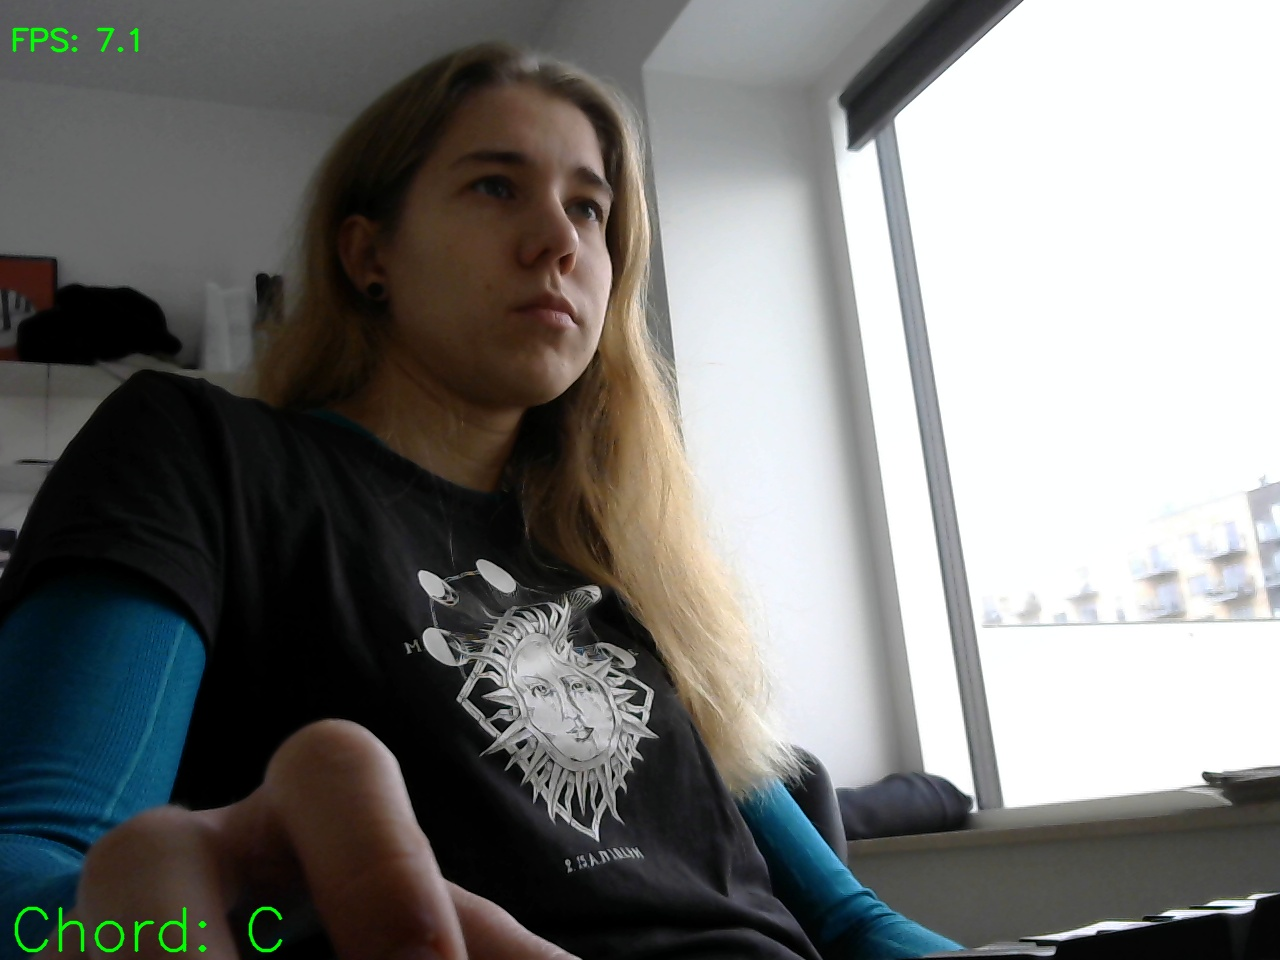

In [55]:
# Stop button widget
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger',
    tooltip='Description',
    icon='square'
)

font = cv2.FONT_HERSHEY_SIMPLEX
start_time = 0

# Display function
def view(model, button):
    cap = initCameraObject(); # init camera
    display_handle = display(None, display_id=True) # display inside Jupyter Notebook
    
    while True: # video "callback"
        global start_time 
        time = timer() - start_time
        start_time = timer()
        ret, frame = cap.read() # read the frame
        
        if not ret or stopButton.value == True: # if frame can't be read or user clicked the "Stop" button
            cap.release()
            display_handle.update(None)
        
        prediction = predict(model, frame)
        
        # Send predicted class by UDP to computer running our plugin
        sendPredictionUDP(prediction)
        
        # Display predicted class
        cv2.putText(frame, "Chord: " + prediction, (10, frame.shape[0] - 10), font, 2, (0, 255, 0), 2, cv2.LINE_AA, False)
        cv2.putText(frame, "FPS: " + str(round(1 / time,1)), (10, 50), font, 1, (0, 255, 0), 2, cv2.LINE_AA, False)
        
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
        
           
            
# Run
# ================
display(stopButton) # show stop button

cnn_model = loadCNNModel('Models/model_1_weights.h5')

session = K.get_session()
graph = tf.get_default_graph()
graph.finalize() # finalize

thread = threading.Thread(target=view, args=(cnn_model, stopButton,))
thread.start()

### TIMING

In [29]:
model_timing = loadCNNModel('Models/model_1_weights.h5')
N = 1000

start = timer()

for i in range(N):
    prediction = model_timing.predict(np.array([np.ones(model_input_shape)]));
    
end = timer()

avg_time = (end - start) / N


In [38]:
print("Average time of a predicition on N={:d} test samples: {:3f}".format(N, avg_time)) # Average time of prediction
print("Predicted FPS: {:f}".format(1 / avg_time))

Average time of a predicition on N=1000 test samples: 0.049156
Predicted FPS: 20.343231
